In [ ]:
!pip install -q tf-nightly
!pip install -q tensorflow-model-optimization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# create symbolic link
!ln -s "drive/MyDrive/Colab Notebooks/Tensorflow" "./Tensorflow"
!dir

In [2]:
# remove symbolic link train
!rm /home/avncalst/Dropbox/deeplearning/SSD/RealTimeObjectDetection/Tensorflow/workspace/images/train

In [6]:
# create symbolic link to train image folders
!ln -s /home/avncalst/Dropbox/deeplearning/SSD/RealTimeObjectDetection/Tensorflow/workspace/images/train_trim ./Tensorflow/workspace/images/train

# 0. Setup Paths + load modules

In [4]:
import tensorflow as tf
import pandas as pd
import imageio
import re
import random
import cv2
import json
import glob
import pathlib
import PIL

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import numpy as np
import time
import shutil
import os
import argparse
import ntpath
import psutil
from imutils import paths
import PIL.ImageDraw as ImageDraw
# from donkeycar.vehicle import Vehicle
# from donkeycar.parts.datastore import TubHandler


# import silence_tensorflow.auto
from tensorflow.keras.layers import Permute,Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import get_file
from sklearn.model_selection import train_test_split

data_source = 'Tensorflow/workspace/images/source/'
data_left = 'Tensorflow/workspace/images/train/left/'
data_right = 'Tensorflow/workspace/images/train/right/'
data_stop = 'Tensorflow/workspace/images/train/stop/'
data_fly = 'Tensorflow/workspace/images/train/fly/'
data_dir = 'Tensorflow/workspace/images/train'
saved_model_path = "Tensorflow/workspace/models/quant_avc/checkpoint"




# 1. Images

### Convert Donkeycar data files

In [4]:
# Convert donkeycar images (tub-format) to class-files (left,right,fly,stop)

source = '/home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18'
imag_path = 'Tensorflow/workspace/images/train'

# list_json = glob.glob("/home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/*.json")
list_json = glob.glob(source + '/*.json')
# print(list_json[0])
df = pd.DataFrame([pd.read_json(list_json[0],typ='series')])
for itx, f in enumerate(list_json):
    # print(itx,f)
    df1 = pd.DataFrame([pd.read_json(f,typ='series')])
    df = df.append(df1,ignore_index=True)
df = df.drop_duplicates()
df.tail()


left = os.path.join(imag_path, 'left')
if not os.path.exists(left):
        os.makedirs(left)
right = os.path.join(imag_path, 'right')
if not os.path.exists(right):
        os.makedirs(right)
fly = os.path.join(imag_path, 'fly')
if not os.path.exists(fly):
        os.makedirs(fly)
stop = os.path.join(imag_path, 'stop')
if not os.path.exists(stop):
        os.makedirs(stop)

column = df['cam/image_array']
clas = df['user/angle']
 

for angle,fil in zip(clas,column):
    # print(angle,fil)
    if int(10*angle) == -3:
        shutil.copy(source + '/' + fil, left)
        # print(fil)
    if int(10*angle) == 3:
        shutil.copy(source + '/' + fil, right)
        # print(fil)
    if int(10*angle) == -9:
        shutil.copy(source + '/' + fil, fly)
        # print(fil)
    if int(10*angle) == 9:
        shutil.copy(source + '/' + fil, stop)
        # print(fil)

df.head()

,cam/image_array,user/angle,user/throttle,user/mode,milliseconds
0,2011_cam-image_array_.jpg,0.9,0.0,user,204983
2,692_cam-image_array_.jpg,-0.9,0.0,user,70527
3,273_cam-image_array_.jpg,-0.9,0.0,user,27813
4,1873_cam-image_array_.jpg,0.3,0.0,user,190917
5,1144_cam-image_array_.jpg,-0.3,0.0,user,116605


### Convert class images to tub (donkeycar)

In [ ]:


V=Vehicle()

class foto(object):
	def __init__(self):

		print('start foto...')
		self.angle = 0.0
		self.throttle = 0.0
		self.image_array = None
		self.mode = 'user'
		self.data = []
		self.labels = []
		self.idx = 0
		self.recording = False
		self.vehicle = None
		self.running = True
		self.imagePaths = sorted(list(paths.list_images('./mycar/phot_B')))
		# print(self.imagePaths)
		# loop over the input images
		for imagePath in self.imagePaths:
			# load the image, pre-process it, and store it in the data list
			image = cv2.imread(imagePath)
			image = cv2.resize(image, (160, 120))
			# image = cv2.resize(image, (64, 64))		# in case of arducopter
			image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
			# cv2.imshow('foto', image)
			# cv2.waitKey(1)
			# image = img_to_array(image)
			self.data.append(image)

			# extract the class label from the image path and update the
			# labels list
			label = imagePath.split(os.path.sep)[-2]
			if label == "stop":
				label = 0.9
			if label == "left":
				label = -0.3 
			if label == "right":
				label = 0.3
			if label == "fly":
				label = -0.9
			self.labels.append(label)
		# print(data)
		print('#labels:',len(self.labels))

	def run_threaded(self):
		return self.image_array,self.angle, self.throttle, self.mode, self.recording

	def update(self):
		while self.running:
		
			self.image_array = self.data[self.idx]
			lab = self.labels[self.idx]
  
			# angle values will result in np.array with dim 4 @ training
			if lab == -0.9:
				self.recording = True
				self.angle = -0.9 # fly
				# print('\nfly')
			elif lab == -0.3:
				self.recording = True
				self.angle = -0.3
				# print('\nleft')
			elif lab == 0.3:
				self.recording = True 
				self.angle = 0.3
				# print('\nright')
			elif lab == 0.9:        
				self.recording = True
				self.angle = 0.9
				# print('\nstop')

			time.sleep(0.1) # needed to avoid false records (angle=throttle=0)                
		
			self.recording = False
			self.angle = 0
			self.throttle = 0

			if self.idx < len(self.labels)-1:
				self.idx +=1
			else: 
				self.shutdown()
			# print(self.idx)

	def shutdown(self):
		self.running = False
		time.sleep(1)
	

ctr = foto()
V.add(ctr, 
	inputs=[],
	outputs=['cam/image_array','user/angle', 'user/throttle', 'user/mode', 'recording'],
	threaded=True)


class CvImageView(object):

	def run(self, image):
		if image is None:
			return
		try:
			if(image is not None):
            img = PIL.Image.fromarray(image)
            img.show()
		except:
			pass
   

	def shutdown(self):
		cv2.destroyAllWindows() 

disp = CvImageView()
V.add(disp, inputs=["cam/image_array"])

inputs=['cam/image_array',
            'user/angle', 'user/throttle', 
            'user/mode']

types=['image_array',
           'float', 'float',
           'str']

meta=[]

th = TubHandler(path='./mycar/data')
tub = th.new_tub_writer(inputs=inputs, types=types, user_meta=meta)
V.add(tub, inputs=inputs, outputs=["tub/num_records"], run_condition='recording')

V.start()

### Check image doubles

In [7]:
# USAGE
# python detect_and_remove.py --dataset dataset
# python detect_and_remove.py --dataset dataset --remove 1
#----------------------------------------------------------------
# remove = -1
remove = 1
#----------------------------------------------------------------

def dhash(image, hashSize=8):
	# convert the image to grayscale and resize the grayscale image,
	# adding a single column (width) so we can compute the horizontal
	# gradient
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (hashSize + 1, hashSize))

    # compute the (relative) horizontal gradient between adjacent
    # column pixels
    diff = resized[:, 1:] > resized[:, :-1]

    # convert the difference image to a hash and return it
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])


data_dir = pathlib.Path(data_dir)
imagePaths = list(data_dir.glob('left/*')) + list(data_dir.glob('right/*')) + list(data_dir.glob('stop/*')) + list(data_dir.glob('fly/*')) + list(data_dir.glob('source/*'))

# print(list(data_dir.glob('left/*')))


# grab the paths to all images in our input dataset directory and
# then initialize our hashes dictionary
print("[INFO] computing image hashes...")
# imagePaths = list(paths.list_images(args["dataset"]))
hashes = {}

# loop over our image paths
for imagePath in imagePaths:
    # load the input image and compute the hash
    image = cv2.imread(str(imagePath))
    h = dhash(image)
    

    # grab all image paths with that hash, add the current image
    # path to it, and store the list back in the hashes dictionary
    p = hashes.get(h, [])
    p.append(imagePath)
    hashes[h] = p

# loop over the image hashes
for (h, hashedPaths) in hashes.items():
	# check to see if there is more than one image with the same hash
    if len(hashedPaths) > 1:
		# check to see if this is a dry run
        if remove <= 0:
            # initialize a montage to store all images with the same
            # hash
            montage = None

            # loop over all image paths with the same hash
            for p in hashedPaths:
                # load the input image and resize it to a fixed width
                # and height
                image = cv2.imread(str(p))
                image = cv2.resize(image, (150, 150))

                # if our montage is None, initialize it
                if montage is None:
                    montage = image

                # otherwise, horizontally stack the images
                else:
                    montage = np.hstack([montage, image])

            # show the montage for the hash
            print("[INFO] hash: {}".format(h))
            montage = cv2.cvtColor(montage, cv2.COLOR_BGR2RGB)
            img = PIL.Image.fromarray(montage)
            img.show()

 
		# otherwise, we'll be removing the duplicate images
        else:
			# loop over all image paths with the same hash *except*
			# for the first image in the list (since we want to keep
			# one, and only one, of the duplicate images)
            for p in hashedPaths[1:]:
                os.remove(p)
            print("[INFO] doubles removed...")
print("[INFO] finished")

[INFO] computing image hashes...
[INFO] finished


### populate image classes and check images

In [19]:

src = {'source':data_source,'left':data_left,'right':data_right,'stop':data_stop,'fly':data_fly}

#========================================================
dir_select = 'left' # select:left, right,fly,stop,source
#========================================================

imagePats = list(paths.list_images(src[dir_select]))
ntpath.basename(src[dir_select])


width = 640
height = 480
i = 0



for imagePat in imagePats:
    head, tail = ntpath.split(str(imagePat))
    print(i,head)
    print(i,tail)
    i+=1
    im = PIL.Image.open(str(imagePat))
    im = im.resize((width, height), PIL.Image.ANTIALIAS)
    im.save(str(imagePat))
    draw = ImageDraw.Draw(im) 
    draw.line((213,0, 213,480), fill=128,width=3)
    draw.line((426,0, 426,480), fill=128,width=3)
    draw.line((0,160, 640,160), fill=128,width=3)
    draw.line((0,320, 640,320), fill=128,width=3)
    draw.line
    im.show()
    
    while True:
        txt = input("f,r,l,h -select dir,n -no action,b -break,d -delete")
        if txt == dir_select[:1]:
            print('cannot move to working dir')
        else:
            break
        
    if txt == 'f':
        shutil.move(str(imagePat), os.path.join(data_fly, tail))
        print('file moved to folder fly')
    if txt == 'l':
        shutil.move(str(imagePat), os.path.join(data_left, tail))
        print('file moved to folder left')
    if txt == 'r':
        shutil.move(str(imagePat), os.path.join(data_right, tail))
        print('file moved to folder right')        
    if txt == 'h':
        shutil.move(str(imagePat), os.path.join(data_stop, tail))
        print('file moved to folder stop')
    if txt == 'n':
        pass
    if txt == 'b':
        break
    if txt == 'd':
        os.remove(str(imagePat))
        print('file deleted')


    # PIL image.show() yields a new process. To stop kill process with name display
    for proc in psutil.process_iter(): # traverse the current process
        # print(proc.name)
        if proc.name() == "display": # If the name of the process is display
            proc.kill() # Close the process

for proc in psutil.process_iter(): # traverse the current process
        # print(proc.name)
        if proc.name() == "display": # If the name of the process is display
            proc.kill() # Close the process
    
    

75 1111_cam-image_array_.jpg
376 Tensorflow/workspace/images/train/left
376 1506_cam-image_array_.jpg
377 Tensorflow/workspace/images/train/left
377 1353_cam-image_array_.jpg
378 Tensorflow/workspace/images/train/left
378 1063_cam-image_array_.jpg
379 Tensorflow/workspace/images/train/left
379 1174_cam-image_array_.jpg
380 Tensorflow/workspace/images/train/left
380 1234_cam-image_array_.jpg
381 Tensorflow/workspace/images/train/left
381 1087_cam-image_array_.jpg
382 Tensorflow/workspace/images/train/left
382 1133_cam-image_array_.jpg
383 Tensorflow/workspace/images/train/left
383 1631_cam-image_array_.jpg
384 Tensorflow/workspace/images/train/left
384 1130_cam-image_array_.jpg
385 Tensorflow/workspace/images/train/left
385 1164_cam-image_array_.jpg
386 Tensorflow/workspace/images/train/left
386 1378_cam-image_array_.jpg
387 Tensorflow/workspace/images/train/left
387 1492_cam-image_array_.jpg
388 Tensorflow/workspace/images/train/left
388 1198_cam-image_array_.jpg
389 Tensorflow/workspa

# Define data directory containing class data-files

fly      568
left     403
right    213
stop     131
Name: clas, dtype: int64
                                           file_name  \
0  Tensorflow/workspace/images/train/fly/1054_cam...   
1  Tensorflow/workspace/images/train/fly/205_cam-...   
2  Tensorflow/workspace/images/train/fly/679_cam-...   
3  Tensorflow/workspace/images/train/fly/466_cam-...   
4  Tensorflow/workspace/images/train/fly/1532_cam...   

                       image clas  
0  1054_cam-image_array_.jpg  fly  
1   205_cam-image_array_.jpg  fly  
2   679_cam-image_array_.jpg  fly  
3   466_cam-image_array_.jpg  fly  
4  1532_cam-image_array_.jpg  fly  


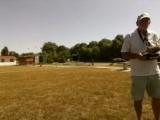

In [8]:

data_dir = pathlib.Path(data_dir)
imags = list(data_dir.glob('*/*.jpg'))
image_count = len(imags)
# print(image_count)
# print(imags[5])
# print(str(imags[5]).split('/'))
imag = list(data_dir.glob('left/*'))

dat = []

for img in imags:
    clas = str(img).split('/')[-2]
    img_name = str(img).split('/')[-1]
    dat.append([str(img),img_name,clas])
df = pd.DataFrame(dat, columns=['file_name','image', 'clas'])
print(df.clas.value_counts())
print(df.head())
# print(df.tail())

PIL.Image.open(str(imag[1]))  



# 2. Train & Validation data

In [9]:
batch_size = 32
epochs = 80
test_size = 0.2

#-----------------------------------------------------------------------------
transfer = False # True: transfer learning MobileNeetV2; False: custom model
#-----------------------------------------------------------------------------

if not transfer:
    img_size = (64,64) # custom CNN
else:
    img_size = (128,128) # MobileNetV2 image sizes (128, 128), (160, 160), (192, 192), or (224, 224)
 

train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
# print(train_df.head())

# validation_split reserves the last images for validation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0,# 10
    height_shift_range=0,# 0.2
    rescale=1./255,
    brightness_range=[0.7,1.1],
    zoom_range=0, # 0.1=>[0.9,1.1] 90% zoom in, 110% zoom out, zoom value random sampled in range [0.9,1.1]
    )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    )


train_ds = train_datagen.flow_from_dataframe(
    train_df,
    x_col="file_name",
    y_col="clas",
    target_size=img_size,
    class_mode="categorical",
    batch_size=batch_size,
    )

val_ds = test_datagen.flow_from_dataframe(
    test_df,
    x_col="file_name",
    y_col="clas",
    target_size=img_size,
    class_mode="categorical",
    batch_size=batch_size,    
    )


steps_per_epoch = train_ds.samples//batch_size
validation_steps = val_ds.samples//batch_size
print('steps_per_epoch:',steps_per_epoch) 
print('validation_steps:',validation_steps)
print(train_df.head())      


Found 1052 validated image filenames belonging to 4 classes.
Found 263 validated image filenames belonging to 4 classes.
steps_per_epoch: 32
validation_steps: 8
                                             file_name  \
209  Tensorflow/workspace/images/train/fly/193_cam-...   
312  Tensorflow/workspace/images/train/fly/236_cam-...   
140  Tensorflow/workspace/images/train/fly/871_cam-...   
905  Tensorflow/workspace/images/train/left/1611_ca...   
783  Tensorflow/workspace/images/train/left/1395_ca...   

                         image  clas  
209   193_cam-image_array_.jpg   fly  
312   236_cam-image_array_.jpg   fly  
140   871_cam-image_array_.jpg   fly  
905  1611_cam-image_array_.jpg  left  
783  1395_cam-image_array_.jpg  left  


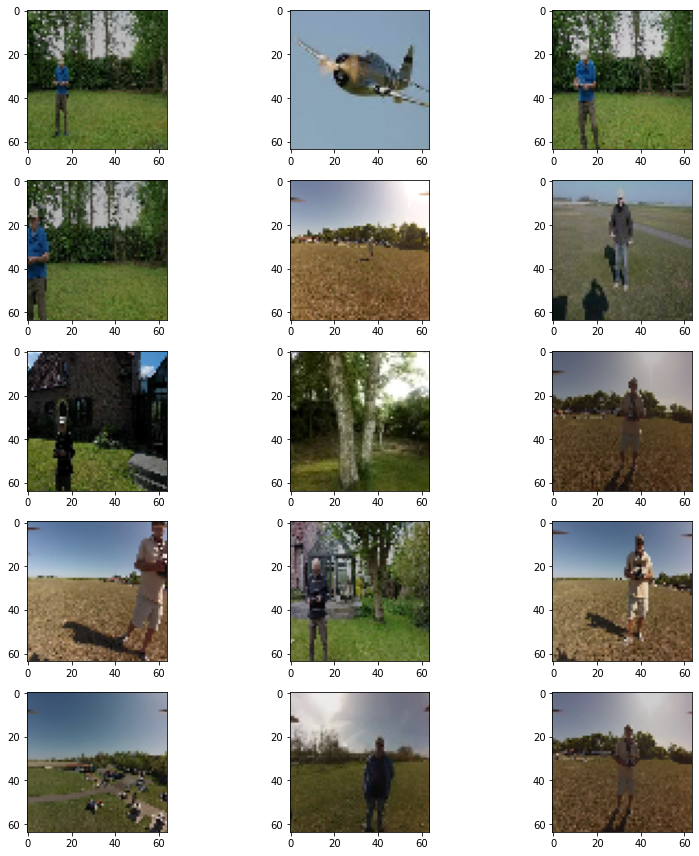

In [4]:

plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i + 1)
    for X_batch, Y_batch in train_ds:
        image = X_batch[0]
        # print(Y_batch[0])
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()



In [10]:
image_batch, labels_batch = next(iter(train_ds))
# print(labels_batch)
first_image = image_batch[0]
first_label = labels_batch[0]
print(image_batch[0].shape)
print(labels_batch[0].shape)
print(np.min(first_image), np.max(first_image))
print(labels_batch[0])
# print(type(image_batch[0]))



(64, 64, 3)
(4,)
0.0 0.92549026
[1. 0. 0. 0.]


# 3. Model Quantized Transfer Learning

In [11]:
def get_training_model():
    if transfer:
        EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
            input_shape=(img_size[0], img_size[1], 3))
        EXTRACTOR.trainable = True
        class_head = EXTRACTOR.output
        class_head = GlobalAveragePooling2D()(class_head)
        class_head = Dense(512, activation="relu")(class_head)
        class_head = Dropout(0.5)(class_head)
        class_head = Dense(4, activation="softmax")(class_head)
        classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)
        
        return classifier
    
    else:
        # Input
        drop = 0.2
        input_shape=(img_size[0], img_size[1], 3) # image_size (64,64)

        img_in = Input(shape=input_shape, name='img_in')    # First layer, input layer, Shape comes from camera.py resolution, RGB
        x = img_in   


        x1 = Conv2D(24, (5, 5), padding='same')(x)
        x1 = Activation('relu')(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), strides=[2,2])(x1)
        x1 = Dropout(drop)(x1)

        x2 = Conv2D(48, (5, 5), padding='same')(x1)
        x2 = Activation('relu')(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), strides=[2,2])(x2)
        x2 = Dropout(drop)(x2)

        x3 = Conv2D(96, (5, 5), padding='same')(x2)
        x3 = Activation('relu')(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), strides=[2,2])(x3)
        x3 = Dropout(drop)(x3)


        x4 = Flatten()(x3) # OpenCV/dnn does not support flatten
        x4 = Dense(500)(x4)
        x4 = Activation('relu')(x4)
        x4 = Dropout(drop)(x4)

        class_head = Dense(4, activation='softmax', name='class_head')(x4)
        classifier = Model(inputs=[img_in], outputs=[class_head])

        return classifier

# 4. Train model

In [12]:
# steps_per_epoch = train_samples//batch_size
# validation_steps = test_samples//batch_size
# rate = initial_learning_rate / (1 + decay_rate * step / decay_step)

if not transfer:
  INIT_LR = 1e-3 # smaller value lowers error peaks
else:
  INIT_LR = 1e-5



lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate=INIT_LR,
  decay_steps=steps_per_epoch*1,
  decay_rate=0.01,
  staircase=False)

def get_optimizer():
  # return tf.keras.optimizers.RMSprop(lr = 0.001, decay = 1e-6)
  # return tf.keras.optimizers.Adam(lr_schedule)
  # return tf.keras.optimizers.Adam(1e-5)
  return tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / epochs)
 

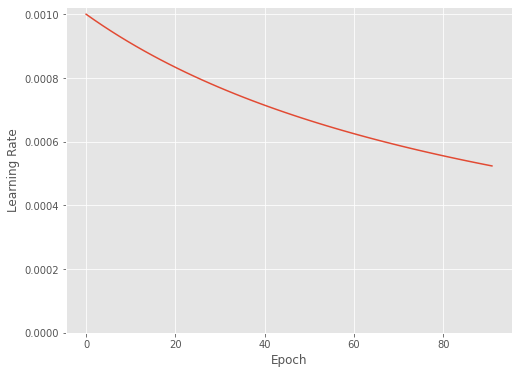

In [77]:
# plot learning rate vs epochs
step = np.linspace(0,1000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/steps_per_epoch, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


In [13]:
optimizer = get_optimizer()


quant_model = get_training_model()
q_quant_model = tfmot.quantization.keras.quantize_model(quant_model) #quantize aware training
q_quant_model.compile(loss="categorical_crossentropy", 
                          optimizer=optimizer,
                          metrics=["accuracy"]
                          )
#STEPS_PER_EPOCH=TRAIN_LENGTH // BATCH_SIZE 
# saved_model_path = "Tensorflow/workspace/models/quant_avc/checkpoint"
checkpointer = ModelCheckpoint(saved_model_path,save_weights_only=True, save_best_only=True,save_freq='epoch', verbose=1)
# save-freq=16 saves after 16 batches, save_freq='epoch' saves after epoch
earlystopping = EarlyStopping(patience=10) # stops after 10 epochs if val_loss did not improve 
callbacks_list = [checkpointer,earlystopping]

start = time.time()
history = q_quant_model.fit(train_ds,
              validation_data=val_ds,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              epochs=epochs,
              callbacks=callbacks_list,
              )
end = time.time()-start
print("Model takes {} seconds to train ",end)
# q_quant_model.save(saved_model_path)

nt_avc/checkpoint
Epoch 25/80
32/32 [==============================] - 35s 1s/step - loss: 0.0325 - accuracy: 0.9910 - val_loss: 0.0870 - val_accuracy: 0.9688

Epoch 00025: val_loss did not improve from 0.06203
Epoch 26/80
32/32 [==============================] - 40s 1s/step - loss: 0.0458 - accuracy: 0.9881 - val_loss: 0.0694 - val_accuracy: 0.9805

Epoch 00026: val_loss did not improve from 0.06203
Epoch 27/80
32/32 [==============================] - 35s 1s/step - loss: 0.0379 - accuracy: 0.9865 - val_loss: 0.1275 - val_accuracy: 0.9688

Epoch 00027: val_loss did not improve from 0.06203
Epoch 28/80
32/32 [==============================] - 40s 1s/step - loss: 0.0321 - accuracy: 0.9906 - val_loss: 0.1078 - val_accuracy: 0.9766

Epoch 00028: val_loss did not improve from 0.06203
Epoch 29/80
32/32 [==============================] - 47s 1s/step - loss: 0.0136 - accuracy: 0.9940 - val_loss: 0.1691 - val_accuracy: 0.9531

Epoch 00029: val_loss did not improve from 0.06203
Epoch 30/80
32/32

34


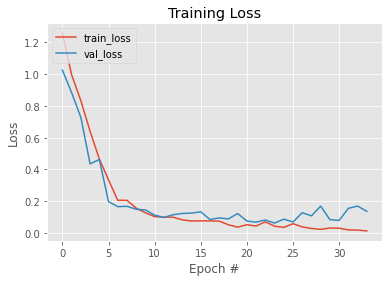

In [14]:
# construct a plot that plots and saves the training history
N = np.arange(0, len(history.history["loss"]))
plt.style.use("ggplot")
plt.figure()
print(len(history.history["loss"]))
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")

### restore model from best saved model

In [15]:
# Loads the weights
q_quant_model.load_weights(saved_model_path)
# q_quant_model=tf.keras.models.load_model(saved_model_path)





# 5. Convert Keras model to Tflite & save model

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_quant_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpwq3qxmef/assets
INFO:tensorflow:Assets written to: /tmp/tmpwq3qxmef/assets


In [17]:
with open('Tensorflow/tflite/w_tflite_model.tflite', 'wb') as f:
  f.write(quantized_tflite_model)

  !ls -lh ./Tensorflow/tflite/w_tflite_model.tflite

-rw-rw-r-- 1 avncalst avncalst 3.1M May 23 16:30 ./Tensorflow/tflite/w_tflite_model.tflite


# 6. Compile via edgetpu_compiler

In [18]:
!edgetpu_compiler ./Tensorflow/tflite/w_tflite_model.tflite -o ./Tensorflow/tflite

Edge TPU Compiler version 15.0.340273435

Model compiled successfully in 1230 ms.

Input model: ./Tensorflow/tflite/w_tflite_model.tflite
Input size: 3.08MiB
Output model: ./Tensorflow/tflite/w_tflite_model_edgetpu.tflite
Output size: 3.25MiB
On-chip memory used for caching model parameters: 3.22MiB
On-chip memory remaining for caching model parameters: 4.54MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 16
Operation log: ./Tensorflow/tflite/w_tflite_model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 14
Number of operations that will run on CPU: 2
See the operation log file for individual operation detail